<a href="https://colab.research.google.com/github/saishruthi2540/SKMLI-164-TASKS-Internship/blob/main/Phase_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import RandomizedSearchCV

# Load the dataset
dataset = pd.read_csv('/content/dataset.csv')
print(dataset.head(3))
print(dataset.columns)

# Fill missing values and encode categorical variables
dataset.fillna("unknown", inplace=True)

# Encode categorical variables
label_encoders = {}
for column in dataset.columns:
    if dataset[column].dtype == 'object':
        le = LabelEncoder()
        dataset[column] = le.fit_transform(dataset[column])
        label_encoders[column] = le

# Print out the classes for each label encoder
for column, le in label_encoders.items():
    print(f"Classes for column '{column}': {le.classes_}")

# Select features (X) and target (y)
X = dataset.drop('Disease', axis=1)  # Assuming 'Disease' is the target column
y = dataset['Disease']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model using RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

# Initialize RandomizedSearchCV with cross-validation
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

# Cross-validation scores
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# Predict on the test data
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

# Save the model for future use
joblib.dump(best_model, 'disease_predictor_model.pkl')

# Function to predict disease based on symptoms
def predict_disease(symptoms):
    # Load the model
    model = joblib.load('disease_predictor_model.pkl')

    # Prepare the symptoms DataFrame
    symptoms_df = pd.DataFrame([symptoms])

    # Ensure all features are present in the DataFrame
    for column in X.columns:
        if column not in symptoms_df.columns:
            symptoms_df[column] = 'unknown'

    # Encode the symptoms using the label encoders
    for column in X.columns:
        if column in label_encoders:
            le = label_encoders[column]
            value = symptoms_df[column].iloc[0]
            if value in le.classes_:
                symptoms_df[column] = le.transform([value])[0]
            else:
                print(f"Warning: Unrecognized value '{value}' for column '{column}'.")
                # Optional: Skip encoding or handle as needed
                symptoms_df[column] = le.transform([le.classes_[0]])[0]  # Use a default value if needed

    # Predict the disease
    prediction = model.predict(symptoms_df)
    disease = label_encoders['Disease'].inverse_transform(prediction)
    return disease[0]

            Disease   Symptom_1              Symptom_2              Symptom_3  \
0  Fungal infection     itching              skin_rash   nodal_skin_eruptions   
1  Fungal infection   skin_rash   nodal_skin_eruptions    dischromic _patches   
2  Fungal infection     itching   nodal_skin_eruptions    dischromic _patches   

              Symptom_4 Symptom_5 Symptom_6 Symptom_7 Symptom_8 Symptom_9  \
0   dischromic _patches       NaN       NaN       NaN       NaN       NaN   
1                   NaN       NaN       NaN       NaN       NaN       NaN   
2                   NaN       NaN       NaN       NaN       NaN       NaN   

  Symptom_10 Symptom_11 Symptom_12 Symptom_13 Symptom_14 Symptom_15  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1        NaN        NaN        NaN        NaN        NaN        NaN   
2        NaN        NaN        NaN        NaN        NaN        NaN   

  Symptom_16 Symptom_17  
0        NaN        NaN  
1        NaN        NaN  
2  

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Cross-validation scores: [1. 1. 1. 1. 1.]
Mean cross-validation score: 1.0
Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        30
           2       1.00      1.00      1.00        24
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        24
           5       1.00      1.00      1.00        23
           6       1.00      1.00      1.00        33
           7       1.00      1.00      1.00        23
           8       1.00      1.00      1.00        21
           9       1.00      1.00      1.00        15
          10       1.00      1.00      1.00        23
          11       1.00      1.00      1.00        26
          12       1.00      1.00      1.00        21
          13       1.00      1.00      1.00        29
          14       1.00      1.00      1.00        24
          15       1.

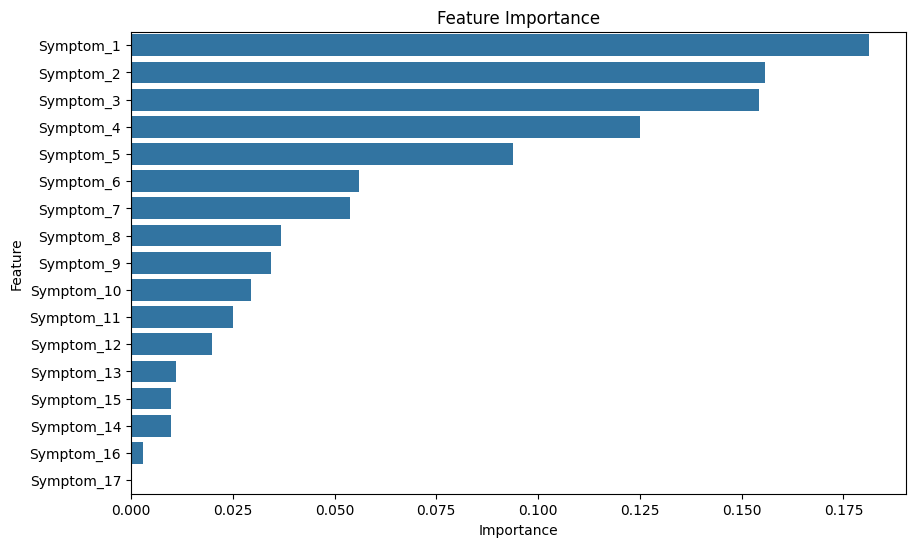

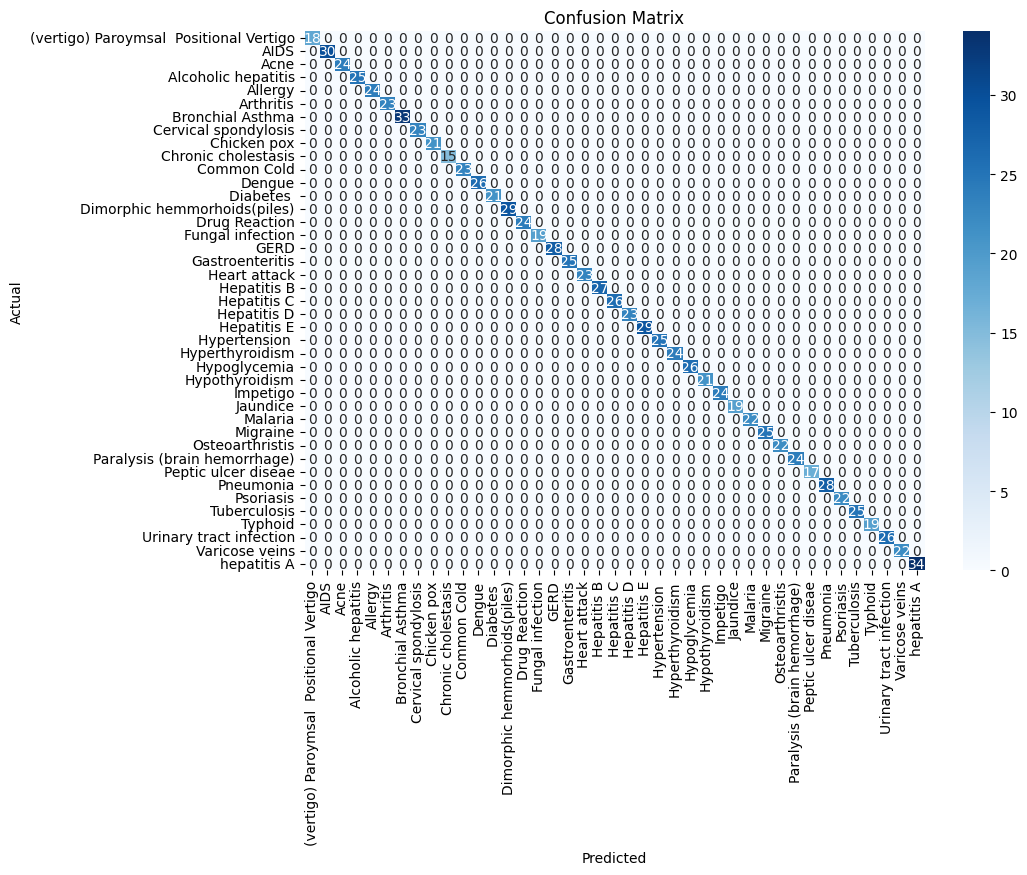

In [7]:
# Plotting Feature Importance
feature_importances = pd.DataFrame(best_model.feature_importances_,
                                   index=X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.importance, y=feature_importances.index)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# Plotting Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoders['Disease'].classes_, yticklabels=label_encoders['Disease'].classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [8]:
# Save the model for future use
joblib.dump(best_model, 'disease_predictor_model.pkl')

# Function to predict disease based on symptoms
def predict_disease(symptoms):
    # Load the model
    model = joblib.load('disease_predictor_model.pkl')

    # Prepare the symptoms DataFrame
    symptoms_df = pd.DataFrame([symptoms])

    # Ensure all features are present in the DataFrame
    for column in X.columns:
        if column not in symptoms_df.columns:
            symptoms_df[column] = 'unknown'

    # Encode the symptoms using the label encoders
    for column in X.columns:
        if column in label_encoders:
            le = label_encoders[column]
            value = symptoms_df[column].iloc[0]
            if value in le.classes_:
                symptoms_df[column] = le.transform([value])[0]
            else:
                print(f"Warning: Unrecognized value '{value}' for column '{column}'.")
                # Optional: Skip encoding or handle as needed
                symptoms_df[column] = le.transform([le.classes_[0]])[0]  # Use a default value if needed

    # Predict the disease
    prediction = model.predict(symptoms_df)
    disease = label_encoders['Disease'].inverse_transform(prediction)
    return disease[0]


In [9]:
# Example usage
symptoms = {
    "Symptom_1": 'itching', "Symptom_2": ' nodal_skin_eruptions', "Symptom_3": ' dischromic _patches',
    "Symptom_4": 'unknown', "Symptom_5": 'unknown', "Symptom_6": 'unknown', "Symptom_7": 'unknown', "Symptom_8": 'unknown',
    "Symptom_9": 'unknown', "Symptom_10": 'unknown', "Symptom_11": 'unknown', "Symptom_12": 'unknown', "Symptom_13": 'unknown',
    "Symptom_14": 'unknown', "Symptom_15": 'unknown', "Symptom_16": 'unknown', "Symptom_17": 'unknown'
}

predicted_disease = predict_disease(symptoms)
print(f"Predicted Disease: {predicted_disease}")

Predicted Disease: Fungal infection
